Predicting the Behavior of the Supreme Court of the United States: A General Approach
==================
  *  __Title__: Predicting the Behavior of the Supreme Court of the United States: A General Approach
  *  __Authors__: [Daniel Martin Katz](http://www.law.msu.edu/faculty_staff/profile.php?prof=780), [Michael J Bommarito II](http://bommaritollc.com/), [Josh Blackman](http://joshblackman.com)
  *  __Paper URL__: [http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2463244](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2463244)
  *  __Blog URL__: [http://lexpredict.com/portfolio/predicting-the-supreme-court/](http://lexpredict.com/portfolio/predicting-the-supreme-court/)

## Paper Abstract
Building upon developments in theoretical and applied machine learning, as well as the efforts of various scholars including Guimera and Sales-Pardo (2011), Ruger et al. (2004), and Martin et al. (2004), we construct a model designed to predict the voting behavior of the Supreme Court of the United States. Using the extremely randomized tree method first proposed in Geurts, et al. (2006), a method similar to the random forest approach developed in Breiman (2001), as well as novel feature engineering, we predict more than sixty years of decisions by the Supreme Court of the United States (1953-2013). Using only data available prior to the date of decision, our model correctly identifies 69.7% of the Court’s overall affirm/reverse decisions and correctly forecasts 70.9% of the votes of individual justices across 7,700 cases and more than 68,000 justice votes. Our performance is consistent with the general level of prediction offered by prior scholars. However, our model is distinctive as it is the first robust, generalized,and fully predictive model of Supreme Court voting behavior offered to date. Our model predicts six decades of behavior of thirty Justices appointed by thirteen Presidents. With a more sound methodological foundation, our results represent a major advance for the science of quantitative legal prediction and portend a range of other potential applications, such as those described in Katz (2013).

## Source Description
The source and data in this repository allow for the reproduction of the results in this paper.  

## Data Description
The data used in this paper is available from the [Supreme Court Database (SCDB)](http://scdb.wustl.edu/).

## Version
The latest version of this model was relesed in October 2015.

In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from model import *

/home/ubuntu/ve/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Get raw data
raw_data = get_raw_scdb_data("data/input/SCDB_2015_01_justiceCentered_Citation.csv")

# Get feature data
feature_df = preprocess_raw_data(raw_data, include_direction=True)

In [3]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(77342, 82)
(77342, 1365)


In [4]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 1                        43951
 0                        26293
-1                         7098
    justice_outcome_disposition
 1                     0.568268
 0                     0.339958
-1                     0.091774


In [5]:
# Setup training time period
min_training_years = 5
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 20

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = raw_data.loc[train_index, "justice_outcome_disposition"].astype(int).values

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = raw_data.loc[test_index, "justice_outcome_disposition"].astype(int).values
    
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "justice"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "justice"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term), 
                                                    class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    n_jobs=-1)
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_data_train, target_data_train)
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)

Term: 1951
Term: 1952
Term: 1953
Natural court change; rebuilding with 160 trees
Term: 1954
Natural court change; rebuilding with 180 trees
Term: 1955
Term: 1956
Natural court change; rebuilding with 220 trees
Term: 1957
Natural court change; rebuilding with 240 trees
Term: 1958
Natural court change; rebuilding with 260 trees
Term: 1959
Natural court change; rebuilding with 280 trees
Term: 1960
Term: 1961
Natural court change; rebuilding with 320 trees
Term: 1962
Natural court change; rebuilding with 340 trees
Term: 1963
Term: 1964
Term: 1965
Natural court change; rebuilding with 400 trees
Term: 1966
Term: 1967
Natural court change; rebuilding with 440 trees
Term: 1968
Term: 1969
Natural court change; rebuilding with 480 trees
Term: 1970
Term: 1971
Natural court change; rebuilding with 520 trees
Term: 1972
Term: 1973
Term: 1974
Term: 1975
Natural court change; rebuilding with 600 trees
Term: 1976
Natural court change; rebuilding with 620 trees
Term: 1977
Term: 1978
Term: 1979
Term: 198

/home/ubuntu/ve/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:487: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


In [6]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = raw_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"]
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.92      0.44      0.60      6700
          0       0.61      0.34      0.43     24325
          1       0.65      0.88      0.75     41142

avg / total       0.66      0.66      0.63     72167

[[ 2975   417  3308]
 [   95  8165 16065]
 [  165  4725 36252]]
0.65669904527

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      6700
          0       0.00      0.00      0.00     24325
          1       0.57      1.00      0.73     41142

avg / total       0.33      0.57      0.41     72167

[[    0     0  6700]
 [    0     0 24325]
 [    0     0 41142]]
0.57009436446



/home/ubuntu/ve/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


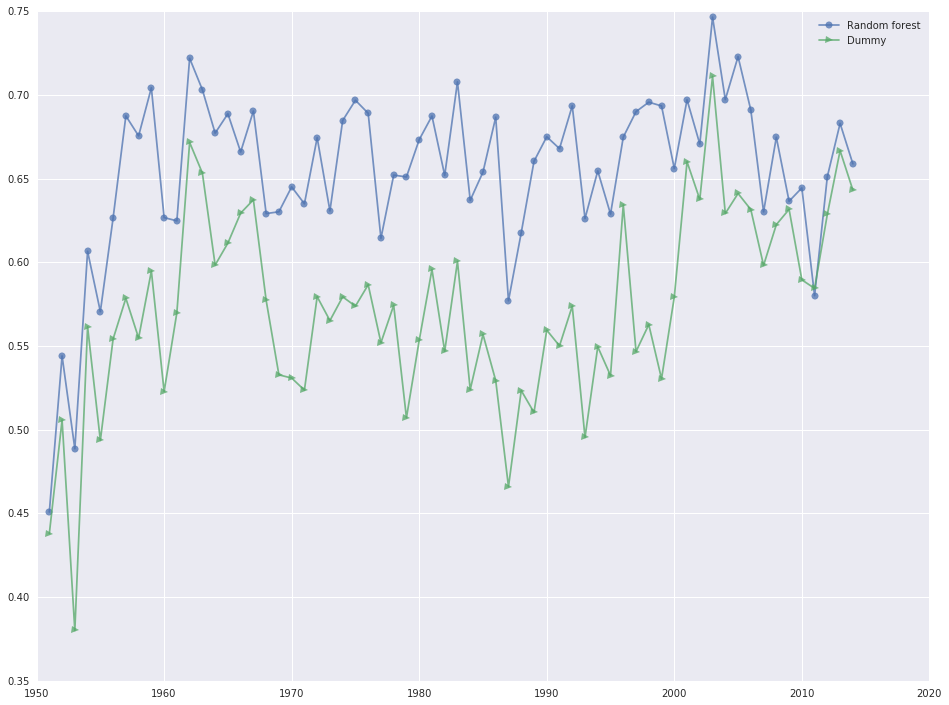

In [7]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

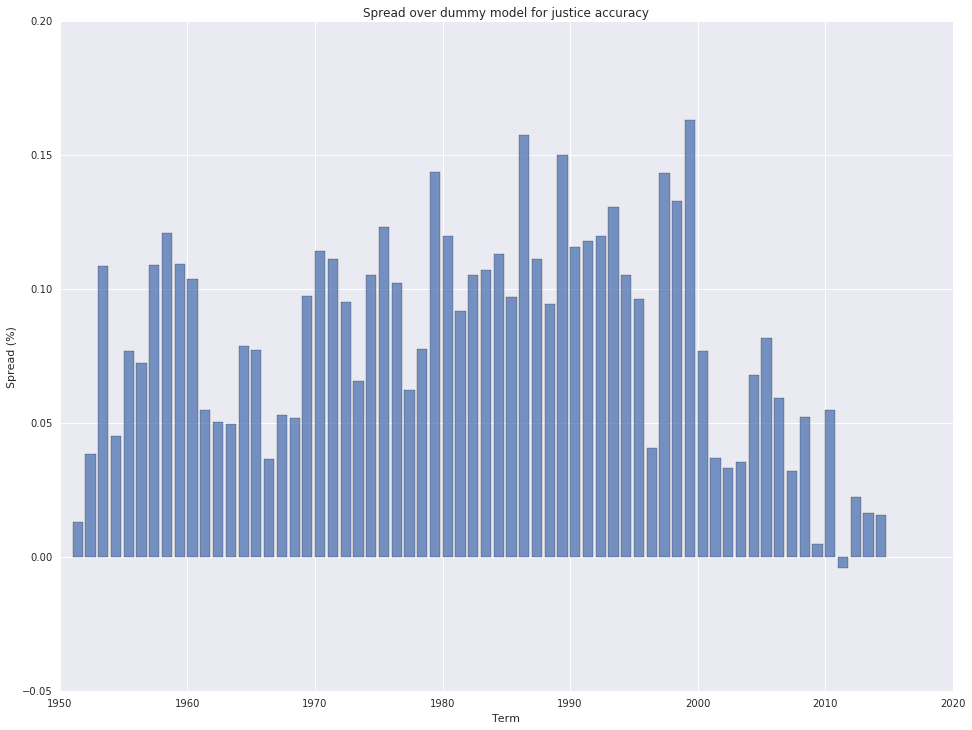

In [8]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [9]:
# Feature importance
feature_importance_df = pandas.DataFrame(zip(feature_df.columns, m.feature_importances_),
                                         columns=["feature", "importance"])
feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
130,decision_delay,0.030604
1364,justice_cumulative_lc_direction_diff,0.026934
1363,justice_previous_lc_direction_diff,0.026517
1352,justice_cumulative_action,0.015373
1357,justice_previous_agreement,0.015324
1154,issue_area_9,0.015277
1351,justice_previous_action,0.015260
1358,justice_cumulative_agreement,0.015200
1346,justice_cumulative_direction,0.014630
1349,justice_previous_court_direction_diff,0.014621


In [10]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=16.269065838625398, pvalue=3.0745658964347267e-24)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=7.1864951269239956, pvalue=6.6475661548431584e-13)
Binomial:
0.0


## Case Outcomes

In [11]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [12]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].agg(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 1    5435
 0    2639
-1     433
Name: case_outcome_disposition, dtype: int64
 1    0.629707
 0    0.305758
-1    0.050168
Name: case_outcome_disposition, dtype: float64


In [13]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = raw_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted_case"]

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.90      0.50      0.64      3676
        0.0       0.54      0.19      0.29     21597
        1.0       0.69      0.92      0.79     45782

avg / total       0.65      0.68      0.63     71055

[[ 1846    72  1758]
 [   63  4205 17329]
 [  144  3567 42071]]
0.677250017592

Dummy model
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00      3676
        0.0       0.00      0.00      0.00     21597
        1.0       0.64      1.00      0.78     45782

avg / total       0.42      0.64      0.50     71055

[[    0     0  3676]
 [    0     0 21597]
 [    0     0 45782]]
0.644317782



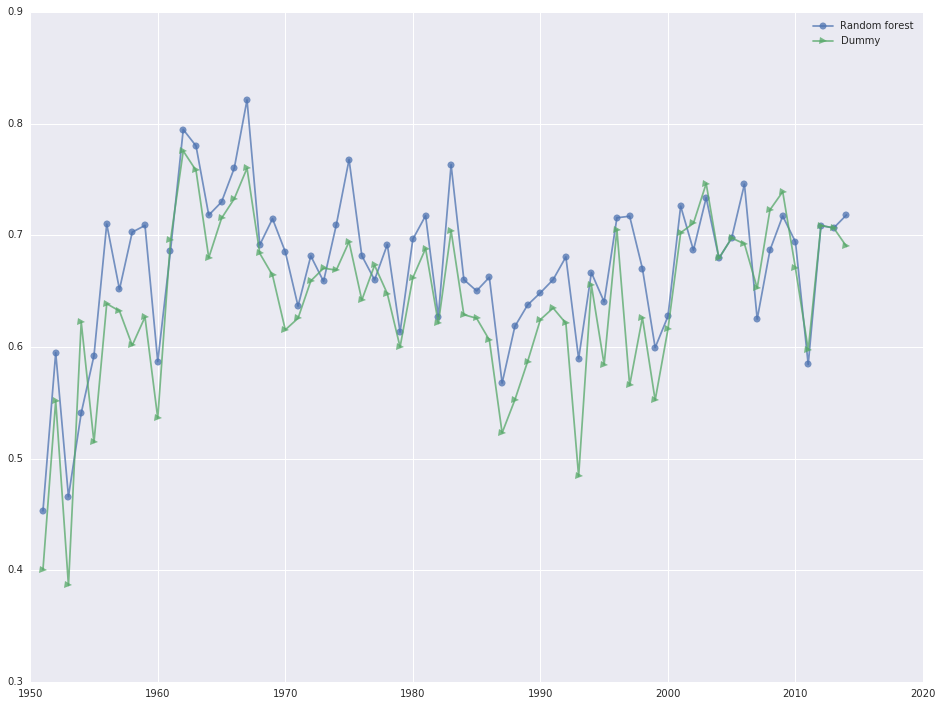

In [14]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

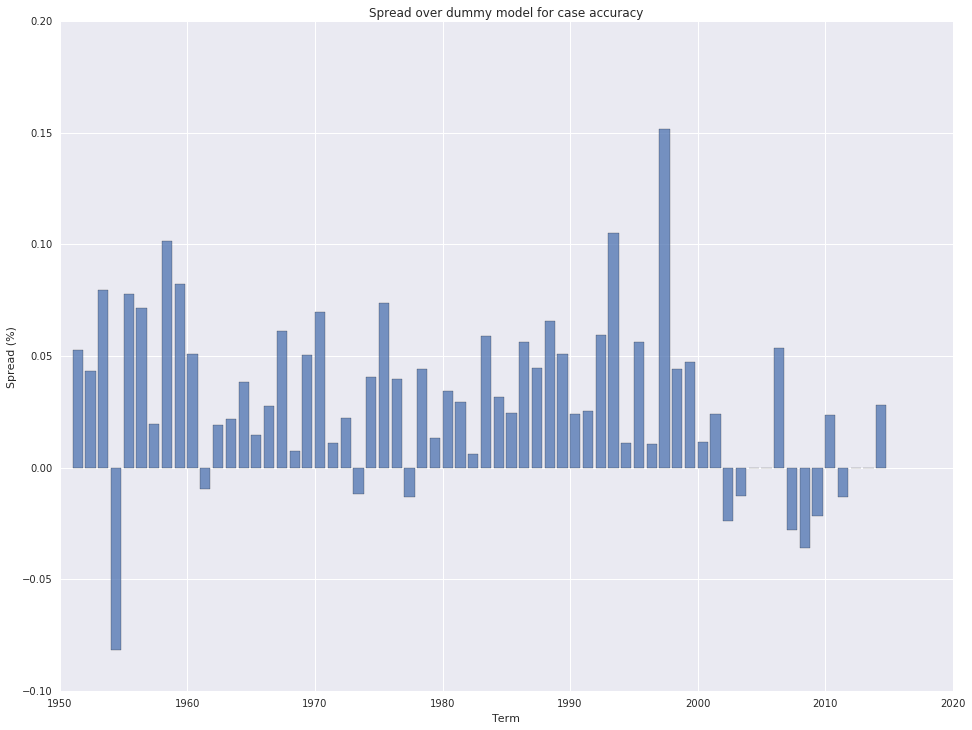

In [15]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

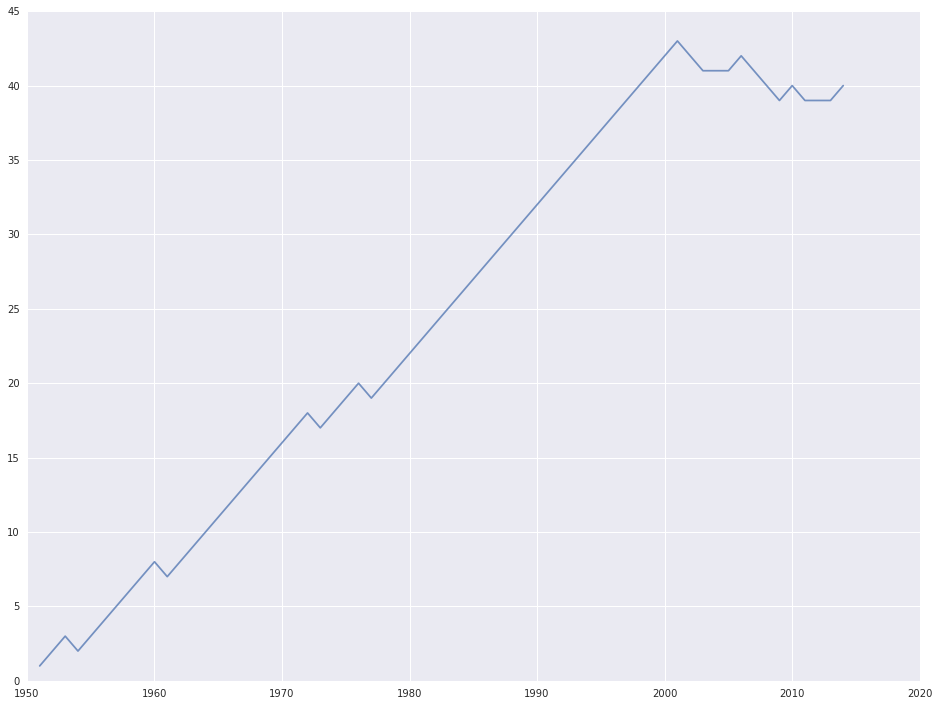

In [16]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [24]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=6.5184373972802172, pvalue=1.3698241936620401e-08)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.4185320138686524, pvalue=0.015583274250562388)
Binomial:
3.25599341663e-10


In [18]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,22281,22282,22283,22284,22285,22286,22287,22288,22289
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,0,1,0,1
rf_predicted_score_affirm,0.505174,0.28,0.1675,0.555,0.3,0.5025,0.185,0.4975,0.3175
rf_predicted_score_reverse,0.479826,0.6825,0.82,0.43,0.655,0.47,0.74,0.4875,0.61
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [19]:
raw_data.loc[raw_data.loc[:, "caseName"] == "OBERGEFELL v. HODGES", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,77288,77289,77290,77291,77292,77293,77294,77295,77296
caseName,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,0,1,0,1,1,0,1,1
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.268116,0.308696,0.260145,0.32029,0.288406,0.266667,0.294203,0.27029,0.249275
rf_predicted_score_reverse,0.697826,0.672464,0.718116,0.662319,0.697101,0.718116,0.684058,0.715942,0.736232
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [20]:
raw_data.loc[raw_data.loc[:, "caseName"] == "KING v. BURWELL", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,77126,77127,77128,77129,77130,77131,77132,77133,77134
caseName,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,0,1,0,1,0,0,1,0,0
rf_predicted,1,0,1,1,0,0,1,0,0
rf_predicted_score_affirm,0.480435,0.504348,0.48913,0.48913,0.581159,0.571014,0.484783,0.598551,0.545652
rf_predicted_score_reverse,0.498551,0.482609,0.492029,0.5,0.399275,0.407246,0.503623,0.385507,0.434058
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [21]:
raw_data.loc[raw_data.loc[:, "caseName"] == 'CITIZENS UNITED v. FEDERAL ELECTION COMMISSION',
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,73130,73131,73132,73133,73134,73135,73136,73137,73138
caseName,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION
justiceName,JGRoberts,JPStevens,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,1,0,1,1,1,0,0,1,0
rf_predicted,1,0,1,1,1,0,0,1,1
rf_predicted_score_affirm,0.314844,0.558594,0.295312,0.316406,0.301563,0.564844,0.521094,0.301563,0.342969
rf_predicted_score_reverse,0.663281,0.402344,0.685156,0.647656,0.677344,0.398438,0.453906,0.68125,0.473438
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [22]:
raw_data.loc[raw_data.loc[:, "caseName"] == 'DISTRICT OF COLUMBIA v. HELLER',
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,72257,72258,72259,72260,72261,72262,72263,72264,72265
caseName,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER
justiceName,JPStevens,AScalia,AMKennedy,DHSouter,CThomas,RBGinsburg,SGBreyer,JGRoberts,SAAlito
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,1,0,0,1,0,1,1,0,0
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.346774,0.4,0.331452,0.340323,0.43629,0.373387,0.331452,0.357258,0.373387
rf_predicted_score_reverse,0.627419,0.575,0.635484,0.631452,0.540323,0.604032,0.642742,0.609677,0.596774
rf_correct_case,0,0,0,0,0,0,0,0,0
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [23]:
# Write output
import cPickle as pickle
import time

timestamp_suffix = time.strftime("%Y%m%d%H%M%S")
raw_data.to_csv("data/output/model_output_{0}_{1}.csv".format(trees_per_term, timestamp_suffix),
                 index=False)
# You probably don't want to do this, as the object can be tens of GB
#pickle.dump(m, open("scotus_scdb_model_{0}.pickle".format(timestamp_suffix), "w"))